# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

**Important note: this notebook was tested only with Python 3.7 and tensorflow 1.13!**

---
## Step 0: Load The Data

In [1]:
# General imports
import time
import pickle
import pathlib


# Load pickled data
training_file = 'data/train.p'
validation_file = 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]  # Number of channes is considered part of the shape!

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))  # 

# Load the classes from signnames.csv to test complempteness of training set
sign_names = {}
with open('signnames.csv', 'r') as fh:
    next(fh)  # Skip header line
    print('Classes')
    for line in fh:
        if len(line) > 0:
            class_id, sign_name = line.strip().split(',')
            sign_names[int(class_id)] = sign_name
            print(f'{class_id}: {sign_name}')
            
assert len(sign_names) == n_classes, f'Training set not complete: it has {n_classes} classes instead of {len(sign_names)}'

print("\nNumber of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Classes
0: Speed limit (20km/h)
1: Speed limit (30km/h)
2: Speed limit (50km/h)
3: Speed limit (60km/h)
4: Speed limit (70km/h)
5: Speed limit (80km/h)
6: End of speed limit (80km/h)
7: Speed limit (100km/h)
8: Speed limit (120km/h)
9: No passing
10: No passing for vehicles over 3.5 metric tons
11: Right-of-way at the next intersection
12: Priority road
13: Yield
14: Stop
15: No vehicles
16: Vehicles over 3.5 metric tons prohibited
17: No entry
18: General caution
19: Dangerous curve to the left
20: Dangerous curve to the right
21: Double curve
22: Bumpy road
23: Slippery road
24: Road narrows on the right
25: Road work
26: Traffic signals
27: Pedestrians
28: Children crossing
29: Bicycles crossing
30: Beware of ice/snow
31: Wild animals crossing
32: End of all speed and passing limits
33: Turn right ahead
34: Turn left ahead
35: Ahead only
36: Go straight or right
37: Go straight or left
38: Keep right
39: Keep left
40: Roundabout mandatory
41: End of no passing
42: End of no passing 

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

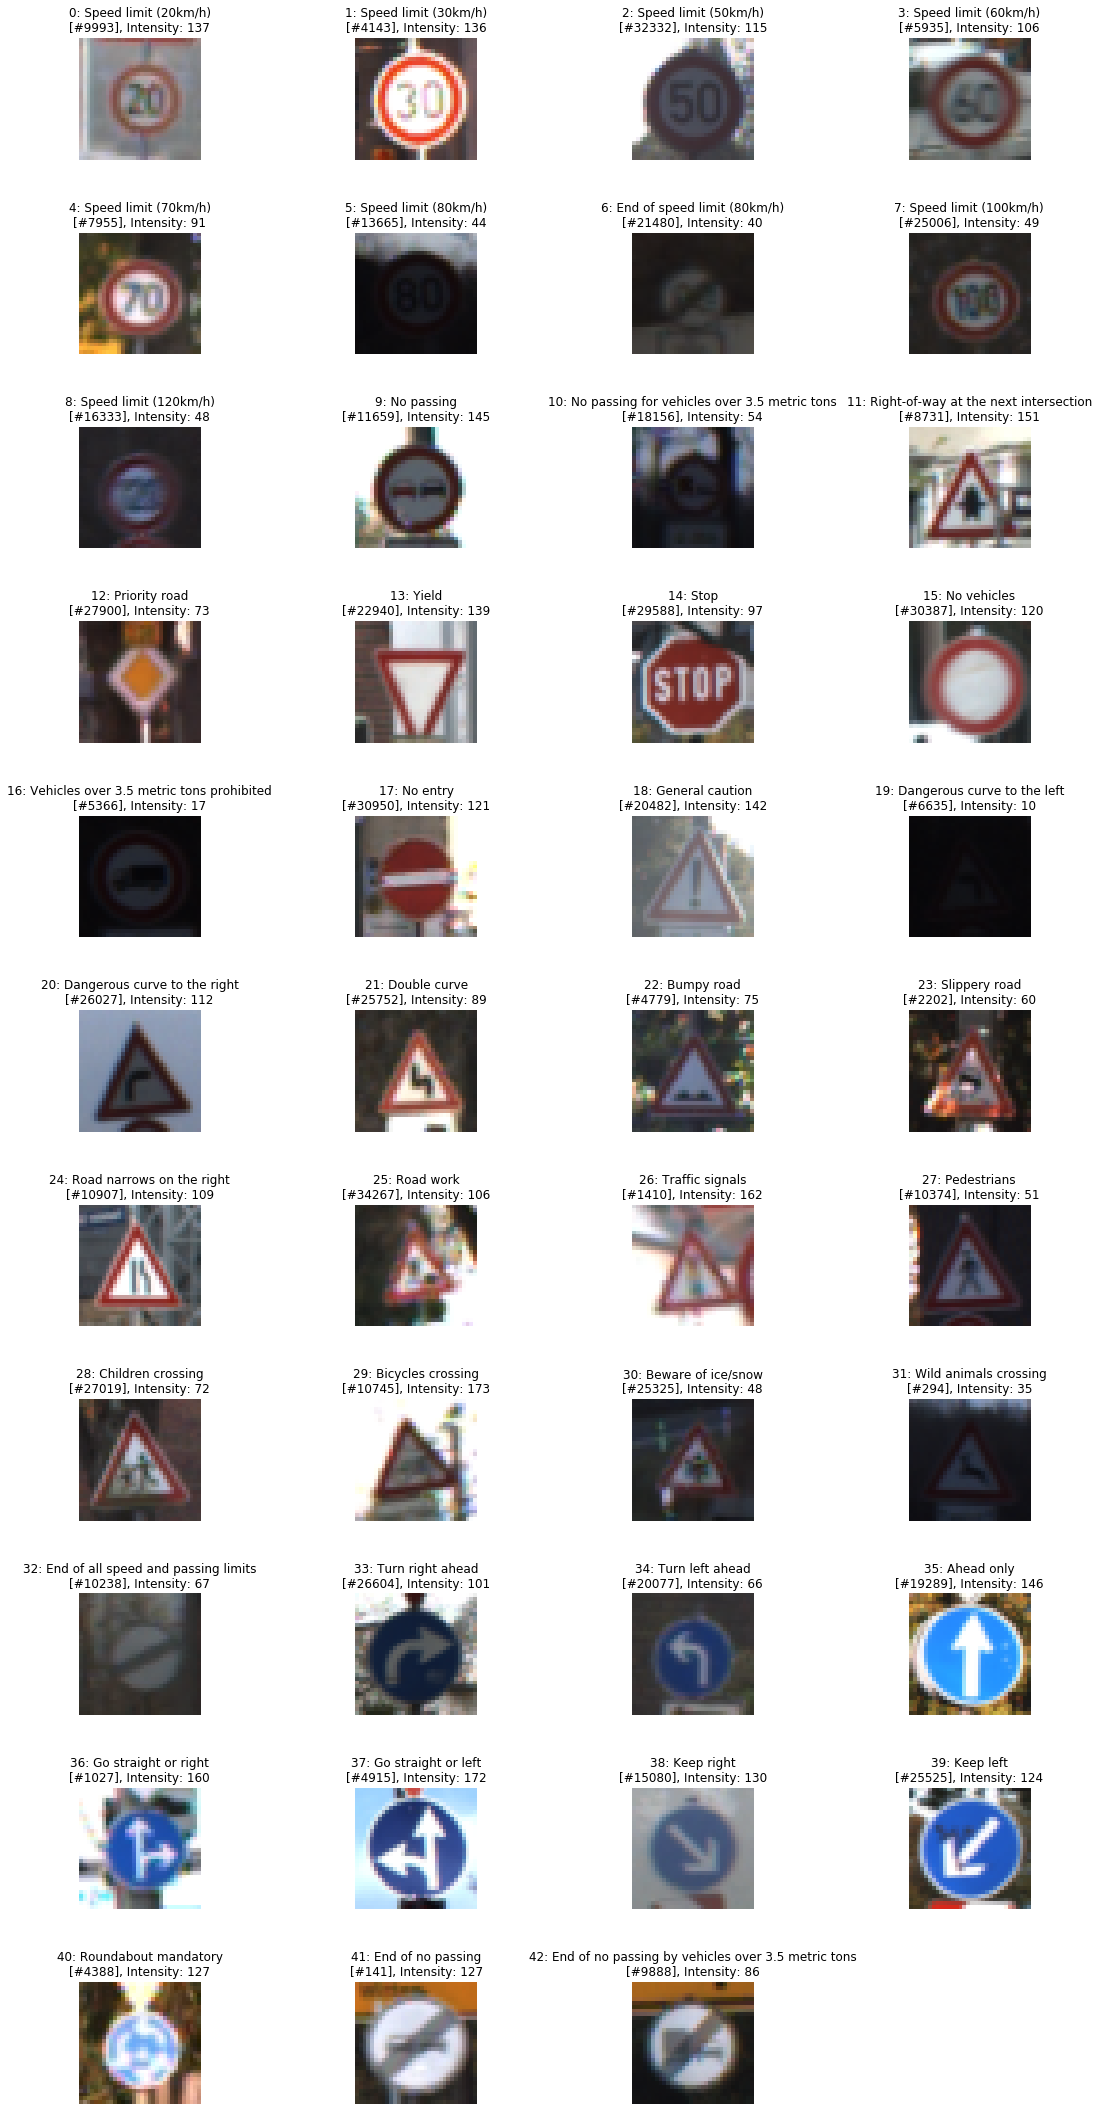

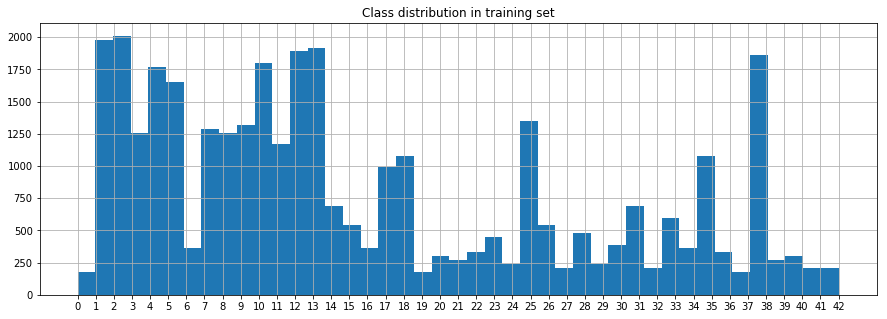

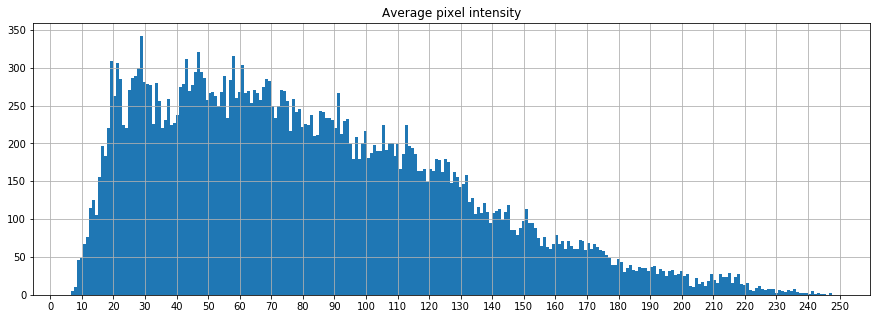

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline


def gen_img_table(num_elements, num_cols, hspace=0.8, figsize=(19, 19)):
    """Generate a table of subplots and return an iterator over the axes"""
    f, axarr = plt.subplots(int(ceil(num_elements / num_cols)), num_cols, figsize=figsize)
    f.subplots_adjust(hspace=hspace)
    for ax in axarr.flatten():
            ax.axis('off')
    for j in range(num_elements):
        row = j // NUM_COLS
        col = (j % NUM_COLS)
        yield axarr[row, col]

        
# Randomly select one example of each class for display
NUM_COLS = 4
for j, ax in zip(range(n_classes), gen_img_table(n_classes, NUM_COLS, hspace=0.6, figsize=(19, 38))):
    instances = list(np.flatnonzero(y_train == j))
    index = random.sample(instances, 1)[0]
    image = X_train[index].squeeze()
    
    ax.imshow(image)
    ax.title.set_text(f'{y_train[index]}: {sign_names[y_train[index]]}\n[#{index}], Intensity: {np.mean(image.flatten()):0.0f}')

# Plot an histogram of the classes
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=n_classes)
plt.xticks(range(n_classes))
plt.grid(True)
plt.title('Class distribution in training set');

# Do a darkness histogram
avg_lightness = np.mean(np.mean(np.mean(X_train, axis=3), axis=2), axis=1)
plt.figure(figsize=(15, 5))
plt.hist(avg_lightness, bins=255)
plt.xticks(np.arange(0, 256, 10))
plt.grid(True)
plt.title('Average pixel intensity');

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Using TensorFlow backend.


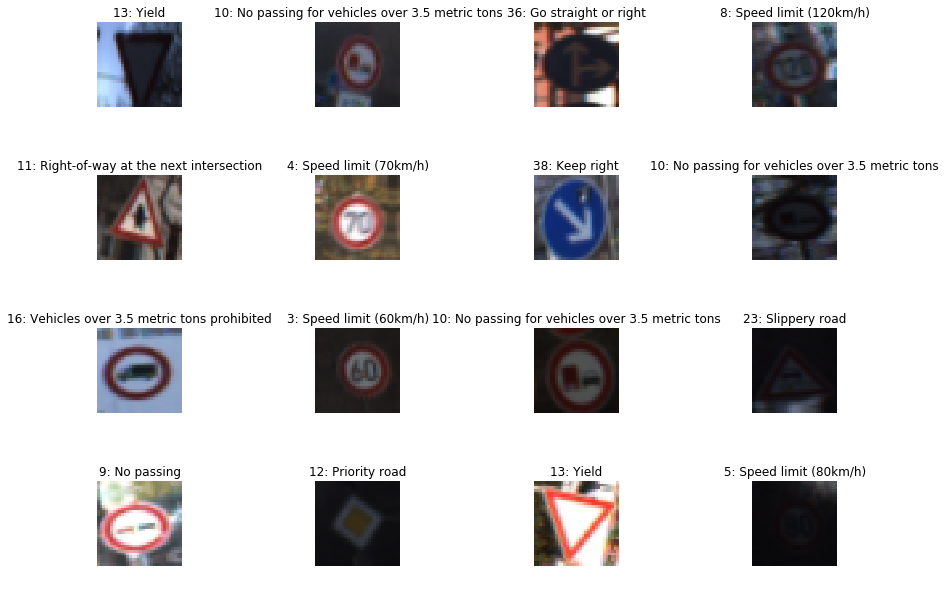

In [4]:
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=2.0,
                               height_shift_range=2.0,
                               shear_range=5.0,
                               zoom_range=[0.8, 1.2],
                               fill_mode='reflect',
                               data_format='channels_last')

# Show a few examples of generated images
bsize = 16
images, classes = next(datagen.flow(X_train, y_train, batch_size=bsize))

for img, instance, ax in zip(images, classes, gen_img_table(bsize, NUM_COLS, figsize=(15, 10))):
    ax.imshow(np.uint8(img))
    ax.title.set_text(f'{instance}: {sign_names[instance]}')

### Model Architecture

In [5]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten


def conv2d(input, shape, mu, sigma, stride=1, padding='VALID', name=None):
    if name is not None:
        w_name = f'{name}_Weights'
        b_name = f'{name}_Bias'
        c_name = f'{name}_conv2d'
        a_name = f'{name}_activation'
        l_name = f'{name}_lrn'
    else:
        w_name = b_name = c_name = a_name = l_name = None    
    w = tf.Variable(tf.truncated_normal(shape, mu, sigma), name=w_name)
    b = tf.Variable(tf.zeros(shape[-1:]), name=b_name)
    layer = tf.nn.conv2d(input, filter=w, strides=[1, stride, stride, 1], padding=padding, name=c_name) + b
    return tf.nn.local_response_normalization(tf.nn.tanh(layer, name=a_name), name=l_name)


def fullcon(input, shape, mu, sigma, use_activation=True, dropout_rate=None, name=None):
    if name is not None:
        w_name = f'{name}_Weights'
        b_name = f'{name}_Bias'
        a_name = f'{name}_activation'
        d_name = f'{name}_dropout'
    else:
        w_name = b_name = a_name = d_name = None    
    w = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma), name=w_name)
    b = tf.Variable(tf.zeros(shape[-1:]), name=b_name)
    fc = tf.matmul(input, w) + b
    if use_activation:
        fc = tf.nn.tanh(fc, name=a_name)
    if dropout_rate is not None:
        fc = tf.nn.dropout(fc, rate=dropout_rate, name=d_name)
    return fc


def LeNet(x, dropout_rate):
    mu = 0
    sigma = 0.1
    
    layers = {}  # Save the layers to output it
    
    # Create a preprocessing layer to generate grayscale and features applicable only to the grayscale
    layers['grayscale'] = tf.image.per_image_standardization(tf.image.rgb_to_grayscale(x))
    layers['color'] = tf.image.per_image_standardization(x)
    
    # Layer 1: Convolutional
    layers['cl_1_g'] = conv2d(layers['grayscale'], [5, 5, 1, 42], mu, sigma, name='C1_gray')
    layers['cl_1_c'] = conv2d(layers['color'], [5, 5, 3, 16], mu, sigma, name='C1_color')

    # Pooling
    layers['cl_1'] = tf.concat((layers['cl_1_g'], layers['cl_1_c']), axis=3)
    layers['cl_1_p1'] = tf.nn.max_pool(layers['cl_1'], [1, 2, 2, 1], [1, 1, 1, 1], padding='VALID')
    layers['cl_1_p2'] = tf.nn.max_pool(layers['cl_1'], [1, 4, 4, 1], [1, 4, 4, 1], padding='VALID')

    # Layer 2: Convolutional
    layers['cl_2'] = conv2d(layers['cl_1_p1'], [5, 5, 58, 108], mu, sigma, name='C2')
    
    # TODO: Pooling
    layers['cl_2_p1'] = tf.nn.max_pool(layers['cl_2'], [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    layers['cl_2_p2'] = tf.nn.max_pool(layers['cl_2'], [1, 4, 4, 1], [1, 4, 4, 1], padding='VALID')

    # Convolutional
    layers['cl_3a'] = conv2d(layers['cl_2_p1'], [1, 1, 108, 70], mu, sigma, name='C3_depth')
    layers['cl_3b'] = conv2d(layers['cl_3a'], [5, 5, 70, 216], mu, sigma, name='C3')
    layers['cl_3'] = tf.nn.max_pool(layers['cl_3b'], [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')

    # Flatten and connect the intermediate layers
    layers['fc_1'] = tf.concat((flatten(layers['cl_1_p2']), flatten(layers['cl_2_p2']), flatten(layers['cl_3'])), axis=1)
    
    # Layer 3: Fully Connected with dropout
    layers['fc_1'] = fullcon(layers['fc_1'], [7486, 240], mu, sigma, dropout_rate=dropout_rate, name='FC1')
    
    # Layer 4: Fully Connected with dropout
    layers['fc_2'] = fullcon(layers['fc_1'], [240, 120], mu, sigma, dropout_rate=dropout_rate, name='FC2')
    
    # Layer 5: Fully Connected
    logits = fullcon(layers['fc_2'], [120, n_classes], mu, sigma, use_activation=False, name='Logits')
    
    return logits, layers

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training

In [6]:
EPOCHS = 200
BATCH_SIZE = 32
DROPOUT = 0.5

In [7]:
def instantiate_network():
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    y = tf.placeholder(tf.int32, (None))
    dropout_rate = tf.placeholder(tf.float32)
    learning_rate = tf.placeholder(tf.float32)

    logits, layers = LeNet(x, dropout_rate)
    one_hot_y = tf.one_hot(y, n_classes)

    # Configure training branch
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_operation = optimizer.minimize(loss_operation)
    
    # Configure prediction branch
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return (training_operation, accuracy_operation, logits, x, y, dropout_rate, learning_rate, layers)

In [8]:
def evaluate(x, y, dropout_rate, accuracy_operation, X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: 0.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [9]:
def check_pause():
    """Find out if a 'pause' file exists. If it does, sleeps until the file is gone.
    Returns the time spent paused (to subtract from statistics).
    
    Used to allow training while still using the computer for other stuff.
    """
    p_file = pathlib.Path('./pause')
    start = time.time()
    paused = False
    while p_file.exists():
        if not paused:
            paused = True
            print('Paused')
        time.sleep(5)
    elapsed = time.time() - start
    if paused:
        print(f'Released. Spent {elapsed/60:.1f} min paused')
    if elapsed < 3:
        elapsed = 0
    return elapsed
    

In [10]:
def do_train(X_train, y_train, X_valid, y_valid):
    rate = 0.0005

    (training_operation, accuracy_operation, _, x, y, dropout_rate, learning_rate, _) = instantiate_network()
    
    saver = tf.train.Saver()
    num_examples = len(X_train)

    accuracy_log = []
    total_paused_time = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        print("Training...")
        print()
        for i in range(EPOCHS):
            start = time.time()
            paused_time = 0
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                        learning_rate: rate, dropout_rate: DROPOUT})
                batch_x, batch_y = next(datagen.flow(batch_x, batch_y, batch_size=BATCH_SIZE))
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, 
                                                        learning_rate: rate, dropout_rate: DROPOUT})
                paused_time += check_pause()
            
            validation_accuracy = evaluate(x, y, dropout_rate, accuracy_operation, X_valid, y_valid)
            accuracy_log.append(validation_accuracy)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            end = time.time() - paused_time
            total_paused_time += paused_time
            paused_time = 0
            print(f'Epoch took: {(end - start)/60:0.03f} min')
            print()
        
        file_name = f'./lenet_traffic_{validation_accuracy:.3f}'
        saver.save(sess, file_name)
        print("Model saved")
    return (accuracy_log, file_name, total_paused_time)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use keras.layers.flatten instead.
Training...

EPOCH 1 ...
Validation Accuracy = 0.945
Epoch took: 1.200 min

EPOCH 2 ...
Validation Accuracy = 0.975
Epoch took: 1.183 min

EPOCH 3 ...
Validation Accuracy = 0.986
Epoch took: 1.176 min

EPOCH 4 ...
Validation Accuracy = 0.988
Epoch took: 1.174 min

EPOCH 5 ...
Validation Accuracy = 0.987
Epoch took: 1.190 min

EPOCH 6 ...
Validation Accuracy = 0.985
Epoch took: 1.175 min

EPOCH 7 ...
Validation Accuracy = 0.986
Epoch took: 1.192 min

EPOCH 8 ...
Validation Accuracy = 0.985
Epoch took: 1.191 min

EPOCH 9 ...
Validation Accuracy = 0.988
Epoch took: 1.186 min

EPOCH 10 ...
Validation Accuracy = 0.985
Epoch took: 1.185 min

EPOCH 11 ...
Validation Accuracy = 0.982
Epoch took: 1.175 min

EPOCH 12 ...
Validation Accuracy = 0.984
Epoch took: 1.189 min

EPOCH 13 ...
Vali

EPOCH 110 ...
Validation Accuracy = 0.987
Epoch took: 1.178 min

EPOCH 111 ...
Validation Accuracy = 0.985
Epoch took: 1.169 min

EPOCH 112 ...
Validation Accuracy = 0.987
Epoch took: 1.176 min

EPOCH 113 ...
Validation Accuracy = 0.988
Epoch took: 1.179 min

EPOCH 114 ...
Validation Accuracy = 0.986
Epoch took: 1.187 min

EPOCH 115 ...
Validation Accuracy = 0.986
Epoch took: 1.186 min

EPOCH 116 ...
Validation Accuracy = 0.988
Epoch took: 1.190 min

EPOCH 117 ...
Validation Accuracy = 0.987
Epoch took: 1.175 min

EPOCH 118 ...
Validation Accuracy = 0.988
Epoch took: 1.187 min

EPOCH 119 ...
Validation Accuracy = 0.991
Epoch took: 1.178 min

EPOCH 120 ...
Validation Accuracy = 0.984
Epoch took: 1.178 min

EPOCH 121 ...
Validation Accuracy = 0.986
Epoch took: 1.180 min

EPOCH 122 ...
Validation Accuracy = 0.988
Epoch took: 1.174 min

EPOCH 123 ...
Validation Accuracy = 0.985
Epoch took: 1.170 min

EPOCH 124 ...
Validation Accuracy = 0.983
Epoch took: 1.174 min

EPOCH 125 ...
Validation 

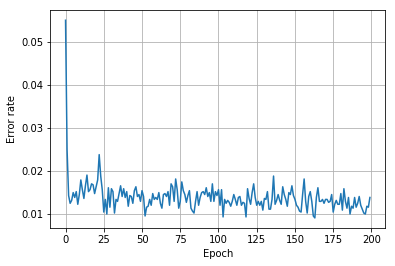

In [11]:
DO_TRAIN = True

import pickle

accuracies = []
if DO_TRAIN:
    start = time.time()
    (accuracies, file_name, total_paused_time) = do_train(X_train, y_train, X_valid, y_valid)
    end = time.time()
    training_time = (end - start - total_paused_time)
    with open('accuracies_log.p', 'wb') as fh:
        pickle.dump((accuracies, training_time), fh)
    print(f'Training took: {training_time/60:0.03f} min')

    plt.plot([1- a for a in accuracies])
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Error rate')

#### Testing

In [12]:
if not DO_TRAIN:
    file_name = 'lenet_traffic_0.986'

tf.reset_default_graph()
(training_operation, accuracy_operation, logits, x, y, dropout_rate, learning_rate, layers) = instantiate_network()

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, file_name)

    training_accuracy = evaluate(x, y, dropout_rate, accuracy_operation, X_train, y_train)
    print(f"Training set accuracy = {training_accuracy:.4f}")
    validation_accuracy = evaluate(x, y, dropout_rate, accuracy_operation, X_valid, y_valid)
    print(f"Validation set accuracy = {validation_accuracy:.4f}")
    test_accuracy = evaluate(x, y, dropout_rate, accuracy_operation, X_test, y_test)
    print(f"Test Accuracy = {test_accuracy:.4f}")    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./lenet_traffic_0.986
Training set accuracy = 0.9999
Validation set accuracy = 0.9862
Test Accuracy = 0.9782


---

## Step 3: Test a Model on New Images

The new images used on this test were taken on my path from work to home (I happen to live in Germany).

Besides a small set of images recognized by the network, two kinds of images not trained were also included on the set:
1. LED-based speed signs
2. Two signs of additional categories, not included in the original data set

My expectation was that the LED speed signs were recognized (at least, as a kind of speed sign, if not with the correct speed) and that the non-trained categories were recognized as similar signs.

### Load the Images

In [13]:
from matplotlib.image import imread

# Extend sign_names with the 'not in dataset' class
sign_names[43] = 'Not part of data set'

# Images were taken on a walk home (they are not from the internet)
img_files = pathlib.Path('./test_images/').glob('*.png')

imgs = []  # Tuples of (img_class, img_path, img_data)
for img_path in img_files:
    img_name = img_path.stem
    img_class = int(img_name[:2])
    img_data =  imread(str(img_path))
    imgs.append((img_class, img_path, img_data))
imgs = sorted(imgs)
n_new_imgs = len(imgs)

In [14]:
print(f'Testing {n_new_imgs} cases')

predicted_classes = []
with tf.Session() as sess:
    saver.restore(sess, file_name)
    for _, _, img_data in imgs:
        preds = sess.run(logits, feed_dict={x: img_data[None, ...], y: 0, dropout_rate: 0.0})
        pred = np.argmax(preds)
        predicted_classes.append(pred)

Testing 52 cases
INFO:tensorflow:Restoring parameters from ./lenet_traffic_0.986


### Predict the Sign Type for Each Image and Analyze Performance

Evaluation accuracy: 0.860


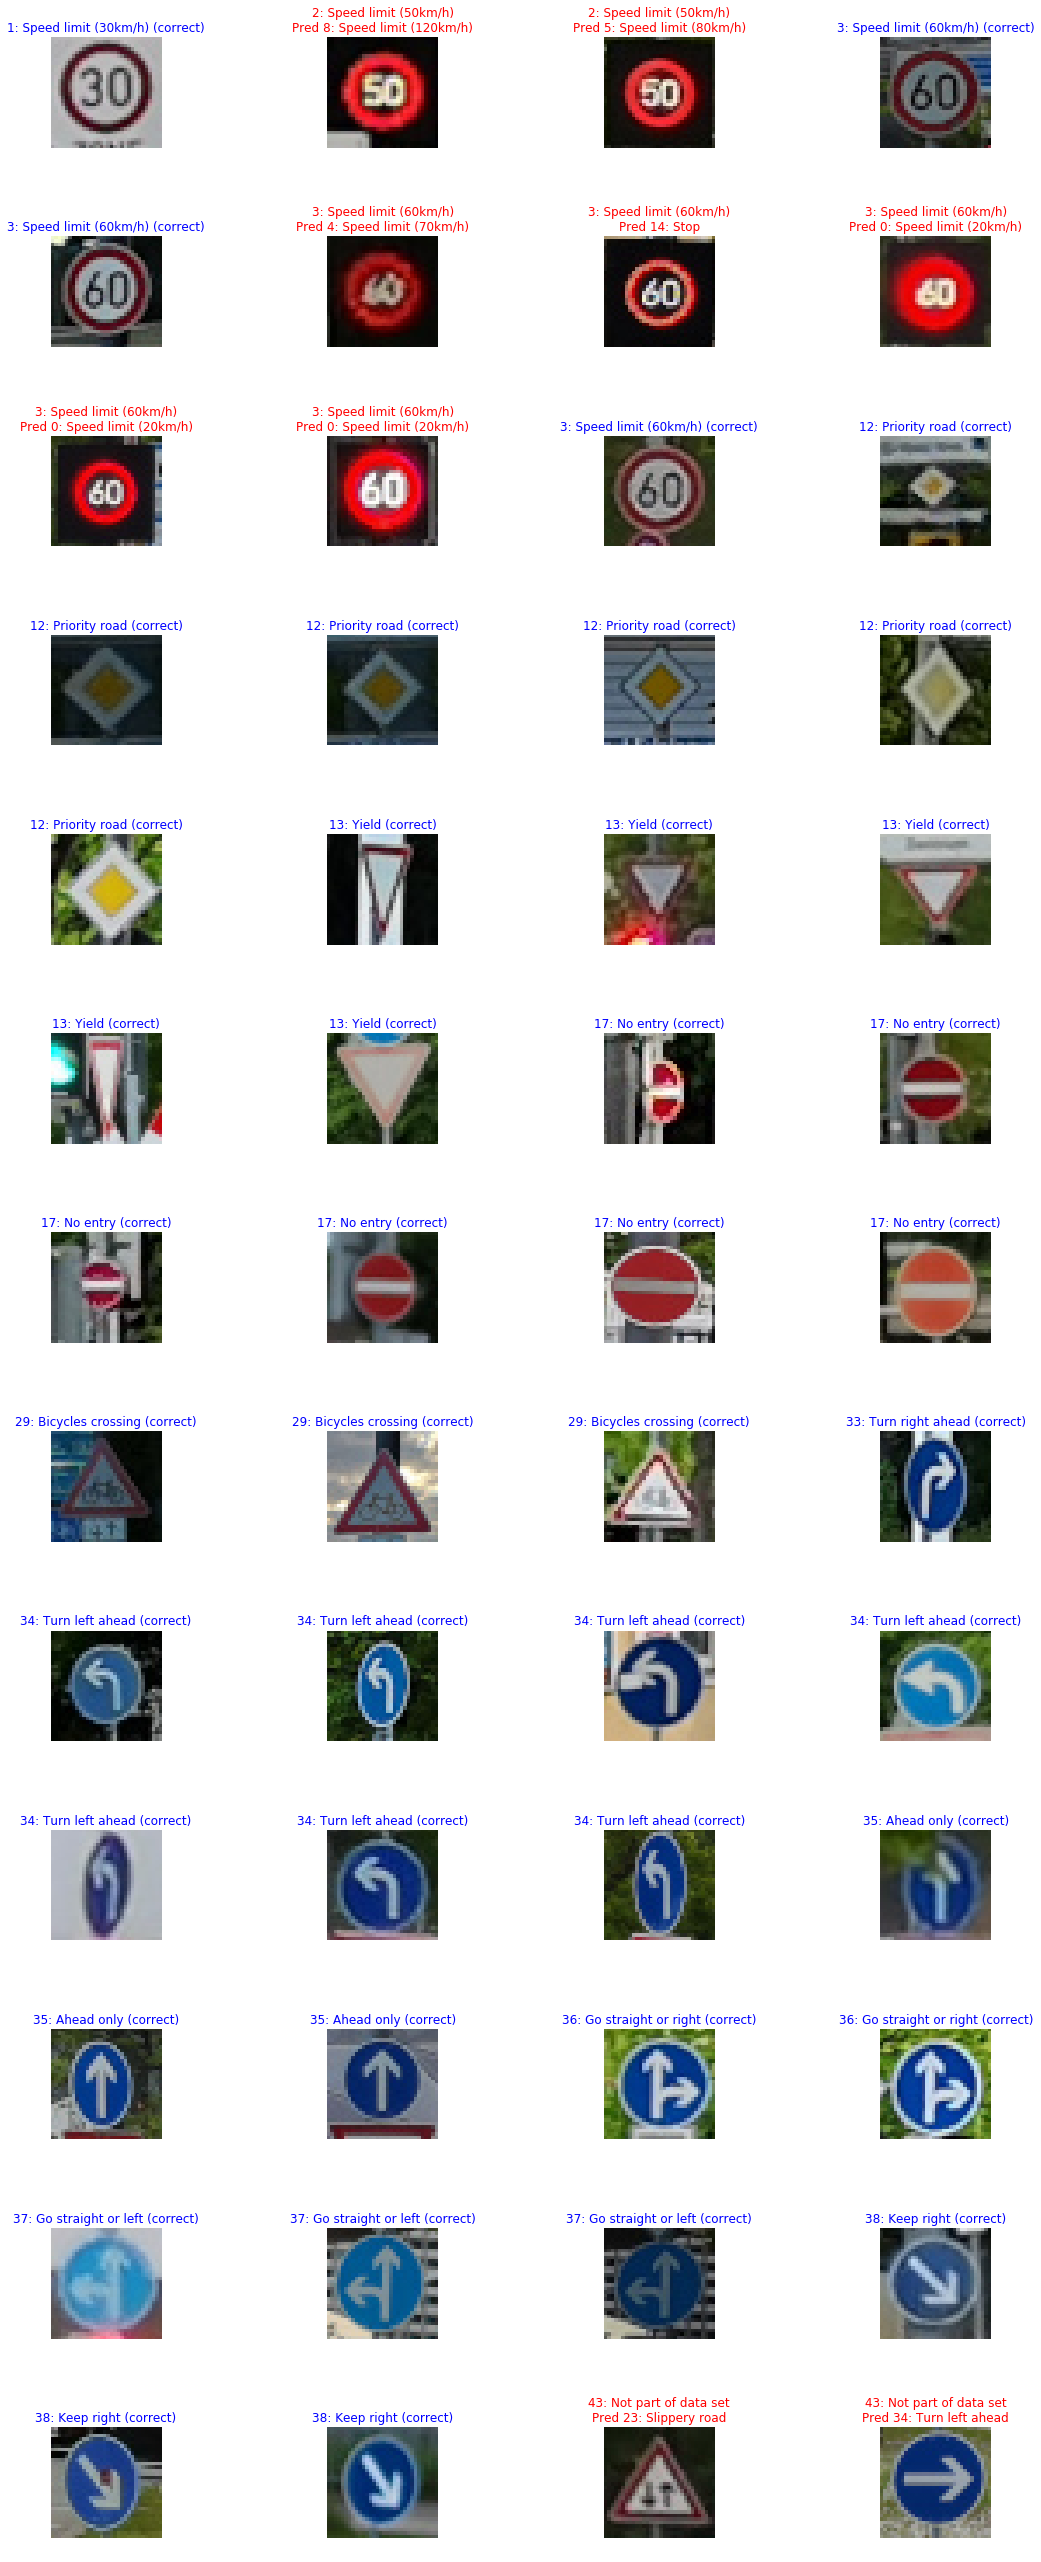

In [15]:
NUM_COLS = 4
accuracy = 0
for img, pred, ax in zip(imgs, predicted_classes, gen_img_table(n_new_imgs, NUM_COLS, hspace=0.8, figsize=(19, 46))):
    img_class, _, img_data = img
    ax.imshow(img_data)
    sign_name = sign_names[img_class]
    if img_class == pred:
        accuracy += 1
        ax.title.set_text(f'{img_class}: {sign_name} (correct)')
        ax.title.set_color('blue')
    else:
        ax.title.set_text(f'{img_class}: {sign_name}\nPred {pred}: {sign_names[pred]}')
        ax.title.set_color('red')
print(f'Evaluation accuracy: {accuracy/(n_new_imgs-2):.3f}')  # Removed the two images that are not on the data set

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

The code and table below show the 5 top-most softmax probabilities for the images abov.

INFO:tensorflow:Restoring parameters from ./lenet_traffic_0.986



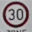
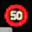
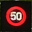
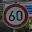
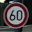
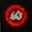
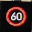
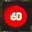
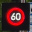
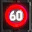
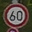
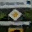
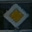
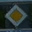
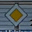
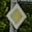
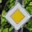
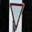
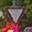
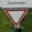
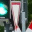
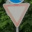
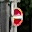
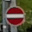
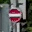
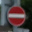
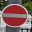
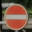
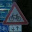
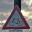
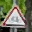
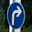
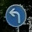
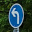
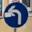
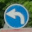
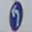
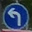
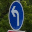
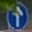
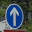
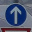
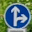
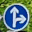
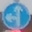
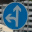
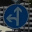
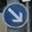
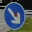
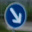
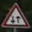
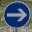

In [16]:
import base64
import IPython.display as dsp

def create_row(i, image_base64, sign_names, img_class, top_preds, top_probabilities, right):
    color = 'green' if right else 'red'
    return f'''
<tr class="no-border-row"><td rowspan="7">{i}</td><td rowspan="7"><img src="data:image/png;base64,{image_base64}" style="width:100px;height:100px;"></td></tr>
<tr class="no-border-row"><td style="font-weight: bold;">{img_class}: {sign_names[img_class]}</tr>
<tr class="no-border-row"><td style="color: {color};">{top_probabilities[0]*100:0.1f}%: {top_preds[0]} - {sign_names[top_preds[0]]}</td></tr>
<tr class="no-border-row"><td>{top_probabilities[1]*100:0.1f}%: {top_preds[1]} - {sign_names[top_preds[1]]}</td></tr>
<tr class="no-border-row"><td>{top_probabilities[2]*100:0.1f}%: {top_preds[2]} - {sign_names[top_preds[2]]}</td></tr>
<tr class="no-border-row"><td>{top_probabilities[3]*100:0.1f}%: {top_preds[3]} - {sign_names[top_preds[3]]}</td></tr>
<tr><td>{top_probabilities[4]*100:0.1f}%: {top_preds[4]} - {sign_names[top_preds[4]]}</td></tr>
'''

table_template = '''
<style>
.rendered_html td {{
    text-align: left;
    padding: 0.2em;
    padding-left: 0.5em;
}}
#ProbTable tr {{
    text-align: left;
    border-bottom: 1px solid #555;
}}
#ProbTable tr.no-border-row {{
    text-align: left;
    border-bottom: none;
}}
</style>

<table  id="ProbTable" style="border-spacing: 0px;padding: 0px;margin: 0px; text-align: left;" rules=rows border=1>{}</table>'''
table_rows = ''

with tf.Session() as sess:
    saver.restore(sess, file_name)
    for i, img in enumerate(imgs):
        img_class, img_path, img_data = img
        image_base64 = base64.b64encode(open(img_path, 'rb').read()).decode('ascii')
        
        top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: img_data[None, ...], y: 0, dropout_rate: 0.0})
        top_classes = top_k.indices.flatten()
        right = img_class == top_classes[0]
        table_rows += create_row(i, image_base64, sign_names, img_class, top_classes, top_k.values.flatten(), right)

dsp.display(dsp.HTML(table_template.format(table_rows)))


---

## Step 4: Visualization of the Neural Network's State

In [17]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1, title=None):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    
    # Plot slightly different things depending on the number of feature maps
    if featuremaps == 1: # Plot like a grayscale image
        size = 3 * (activation.shape[1] / 32)
        plt.figure(plt_num, figsize=(size, size))
        if title is not None:
            plt.title(title)
        plt.imshow(activation[0,:,:,0], interpolation="nearest", cmap="gray")
        plt.show()
    elif featuremaps == 3: # Plot like a color image
        size = 3 * (activation.shape[1] / 32)
        plt.figure(plt_num, figsize=(size, size))
        if title is not None:
            plt.title(title)
        plt.imshow(activation[0,:,:,:], interpolation="nearest")
        plt.show()
    else:
        num_cols = 10
        num_rows = int(ceil(featuremaps / num_cols))
        plt.figure(plt_num, figsize=(19, 2 * num_rows))
        if title is not None:
            plt.suptitle(title)

        for featuremap in range(featuremaps):
            plt.subplot(num_rows, num_cols, featuremap+1)
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.show()
                

In [18]:
# Get the layes that we will be interested in plotting
grayscale_standardization = layers['grayscale']
rgb_standardization = layers['color']
first_convolutional = layers['cl_1_p1']
second_convolutional = layers['cl_2_p1']
third_convolutional = layers['cl_3']

#### Example of input layer standardization

INFO:tensorflow:Restoring parameters from ./lenet_traffic_0.986


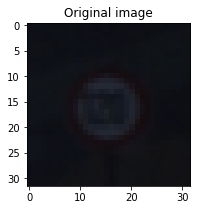

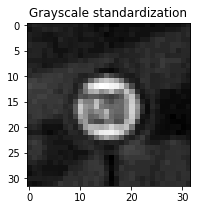

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


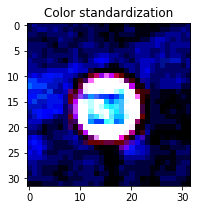

In [19]:
with tf.Session() as sess:
    saver.restore(sess, file_name)
    plt.figure(figsize=(3, 3))
    plt.imshow(X_train[16149, ...],)
    plt.title('Original image')
    plt.show()
    outputFeatureMap(X_train[16149:16150, ...], grayscale_standardization, title='Grayscale standardization')
    outputFeatureMap(X_train[16149:16150, ...], rgb_standardization, title='Color standardization')   
    

#### Analysis of the network response to a LED sign (comparing to a normal 60 km/h sign)

INFO:tensorflow:Restoring parameters from ./lenet_traffic_0.986


#### Data for LED sign

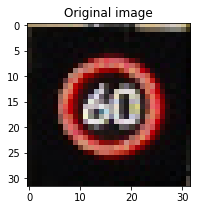

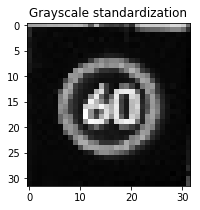

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


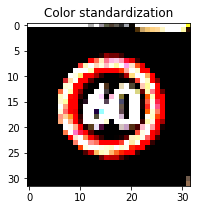

##### First layer for LED sign

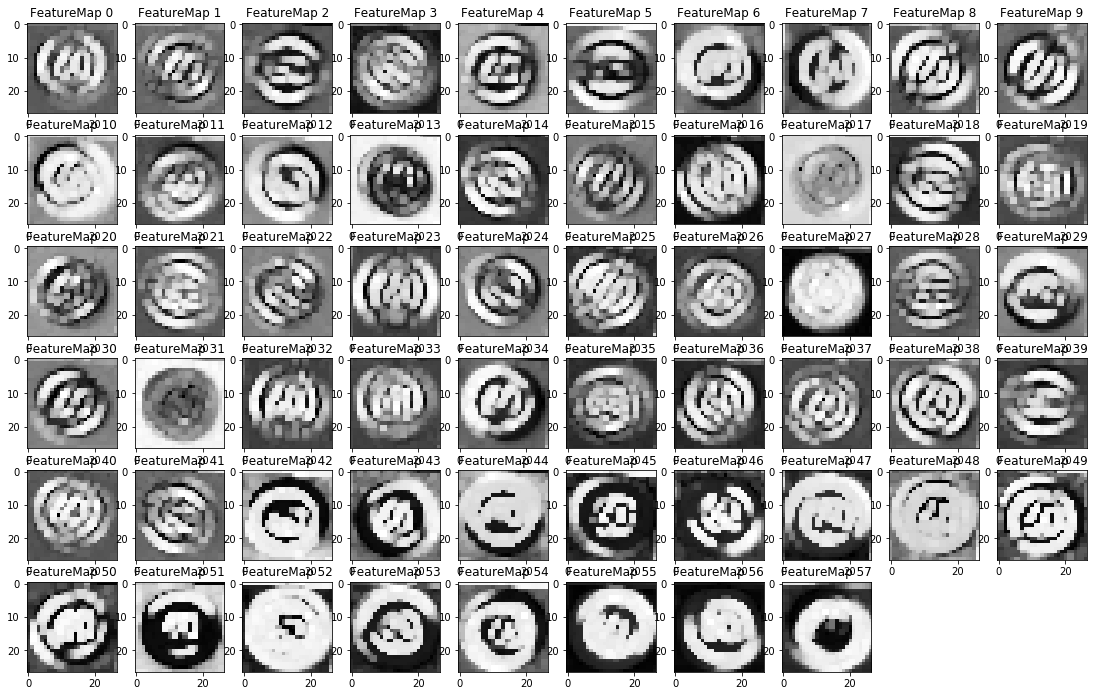

##### Second layer LED sign

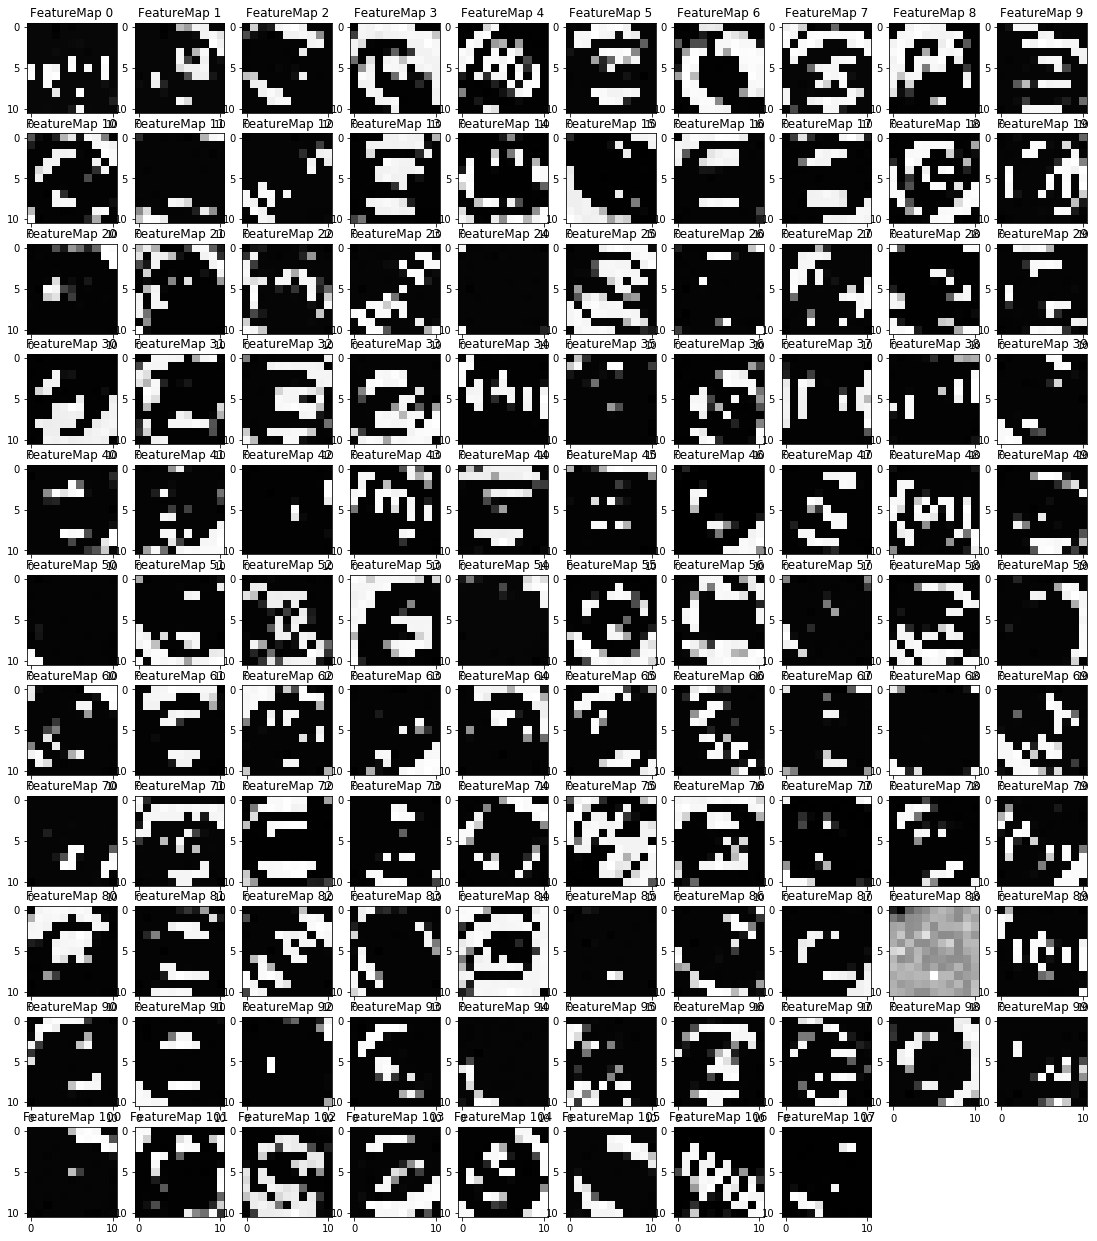

##### Third layer LED sign

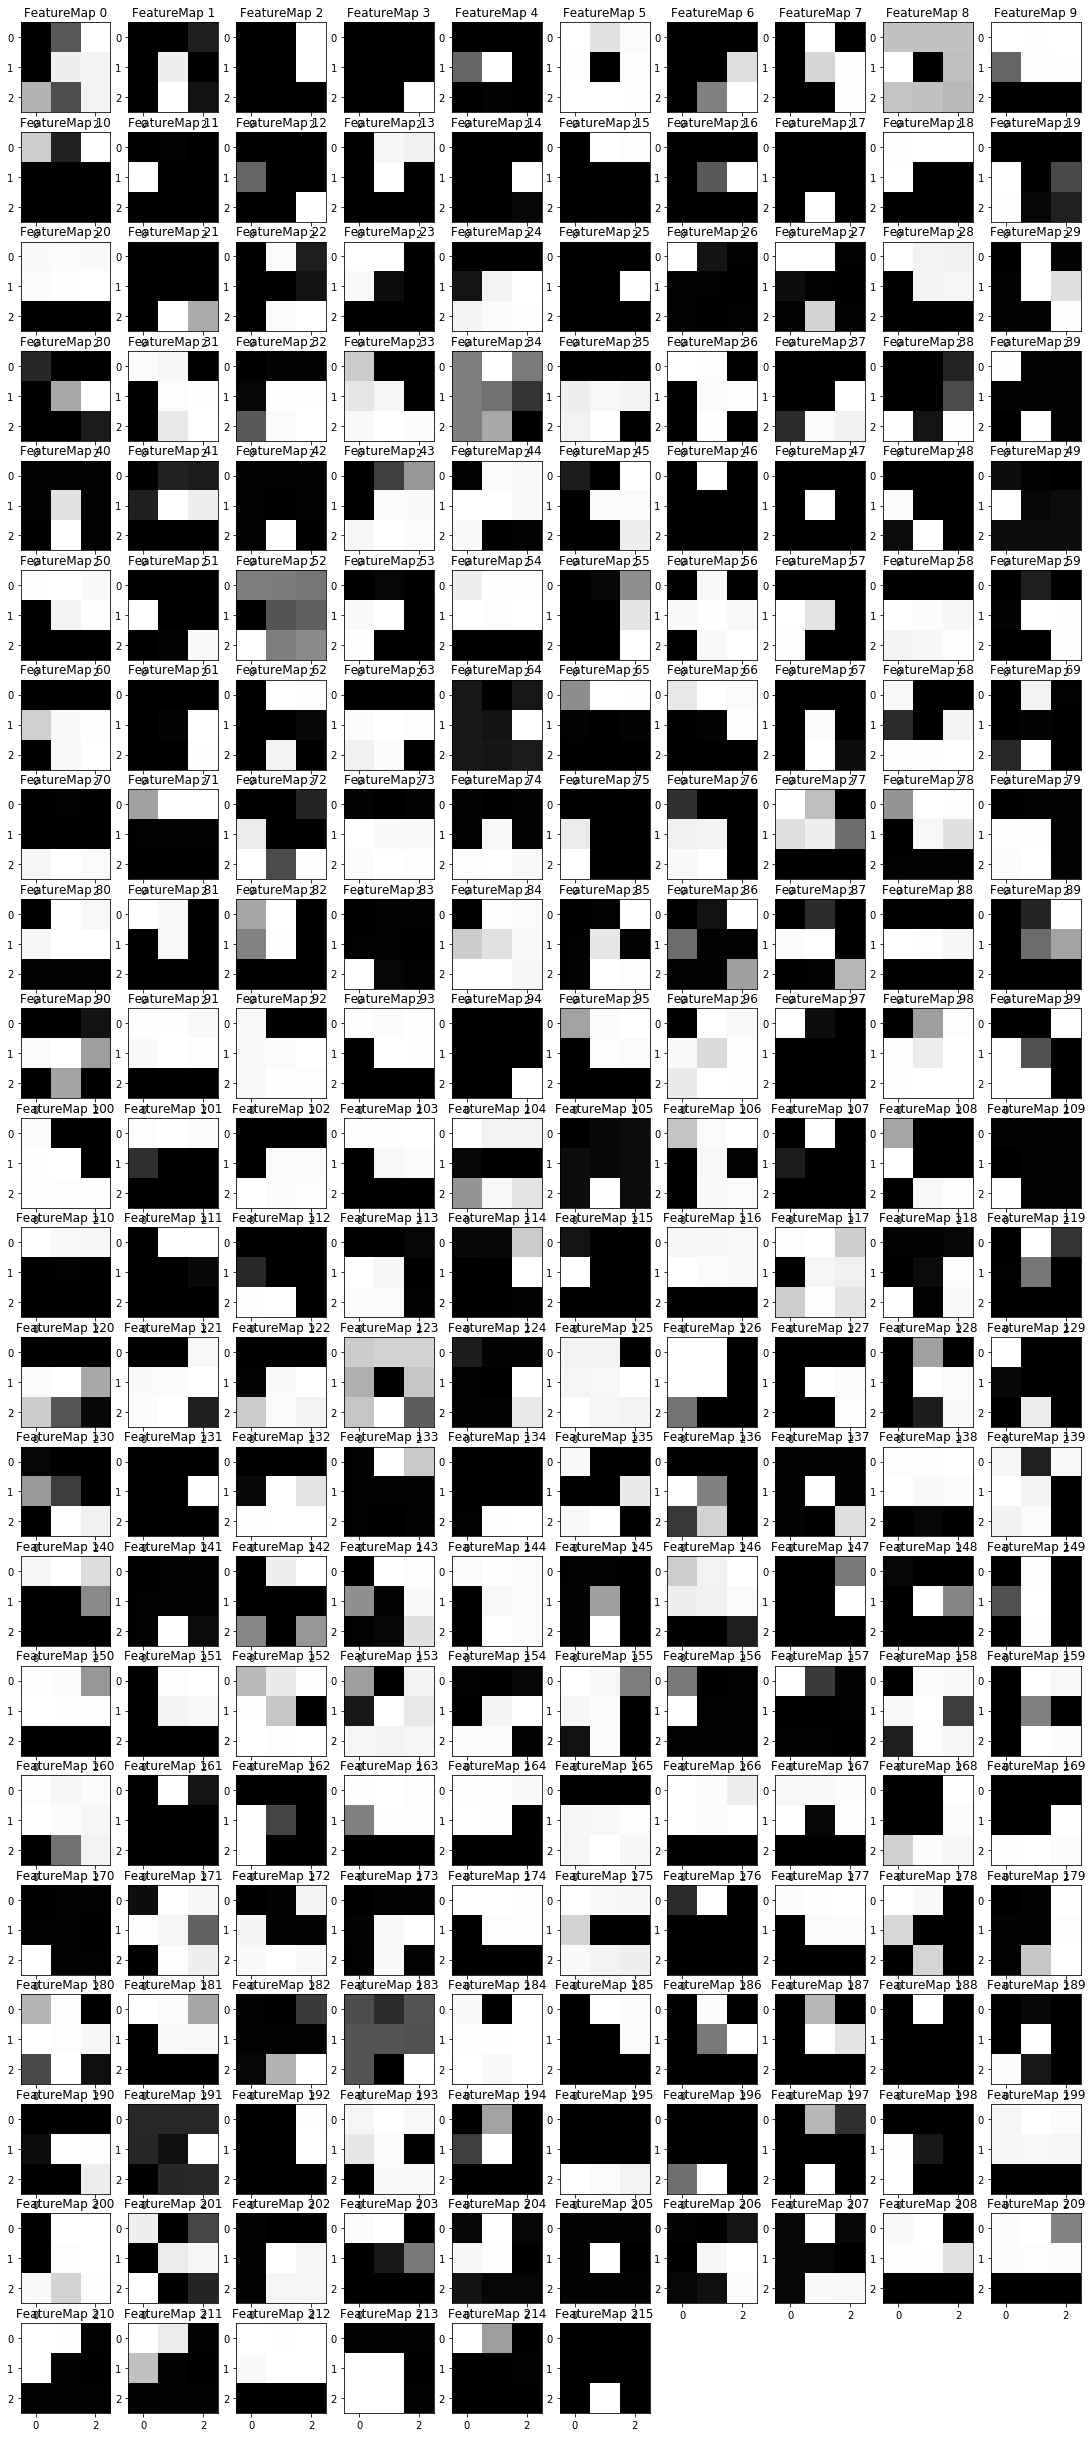

#### Data for Normal sign

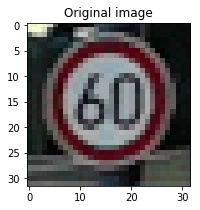

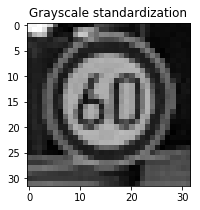

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


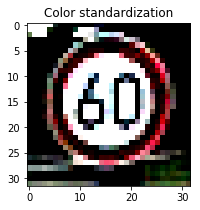

##### First layer for Normal sign

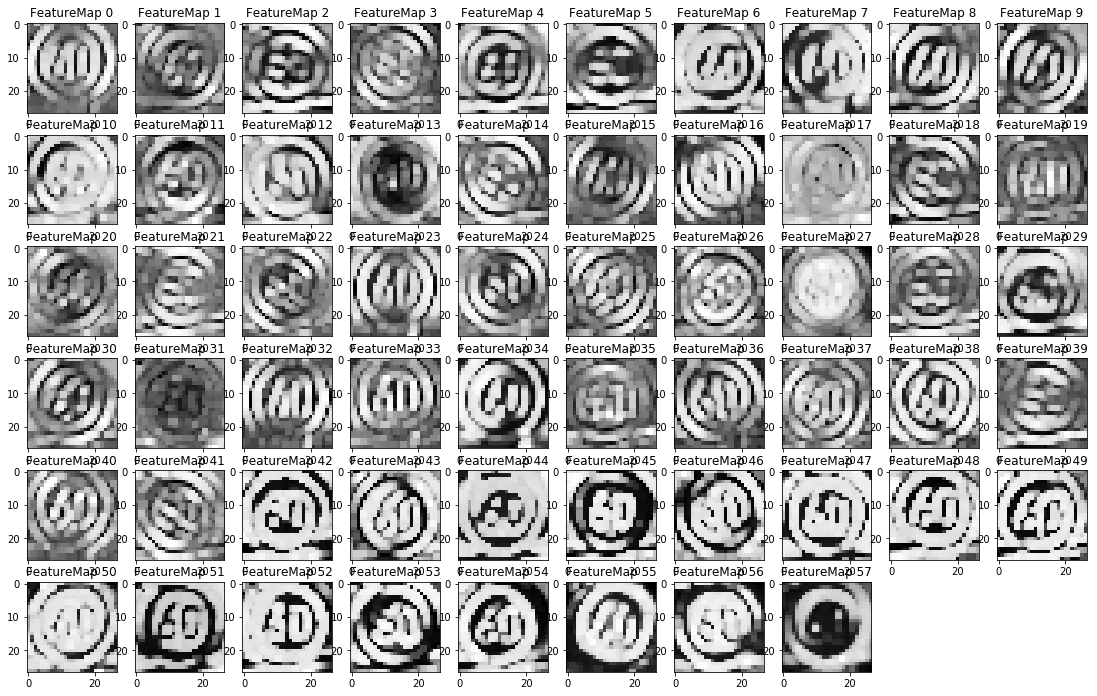

##### Second layer Normal sign

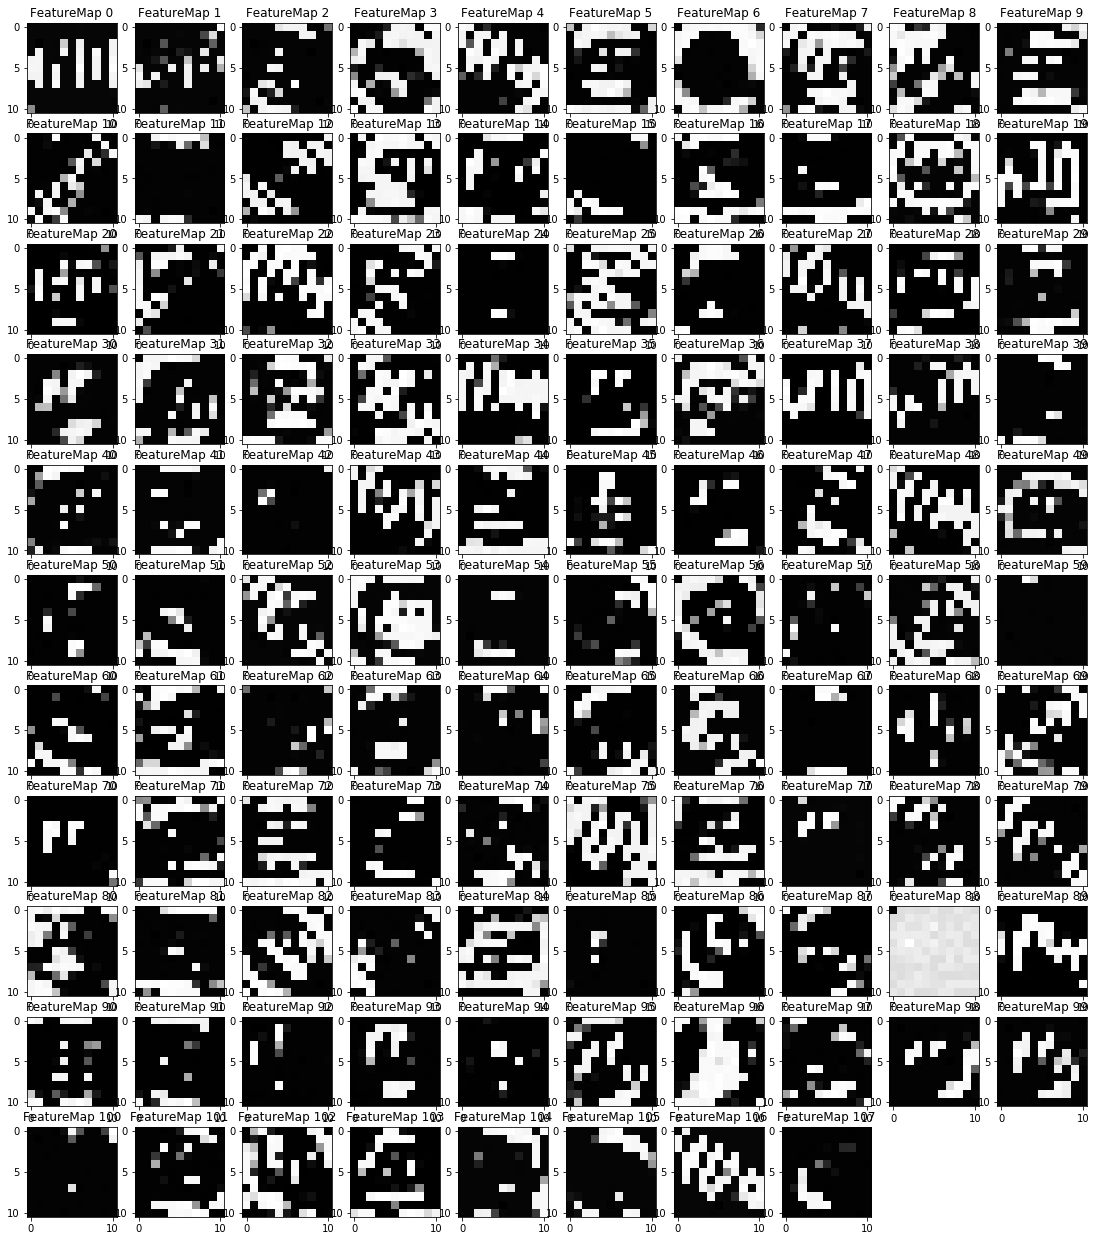

##### Third layer Normal sign

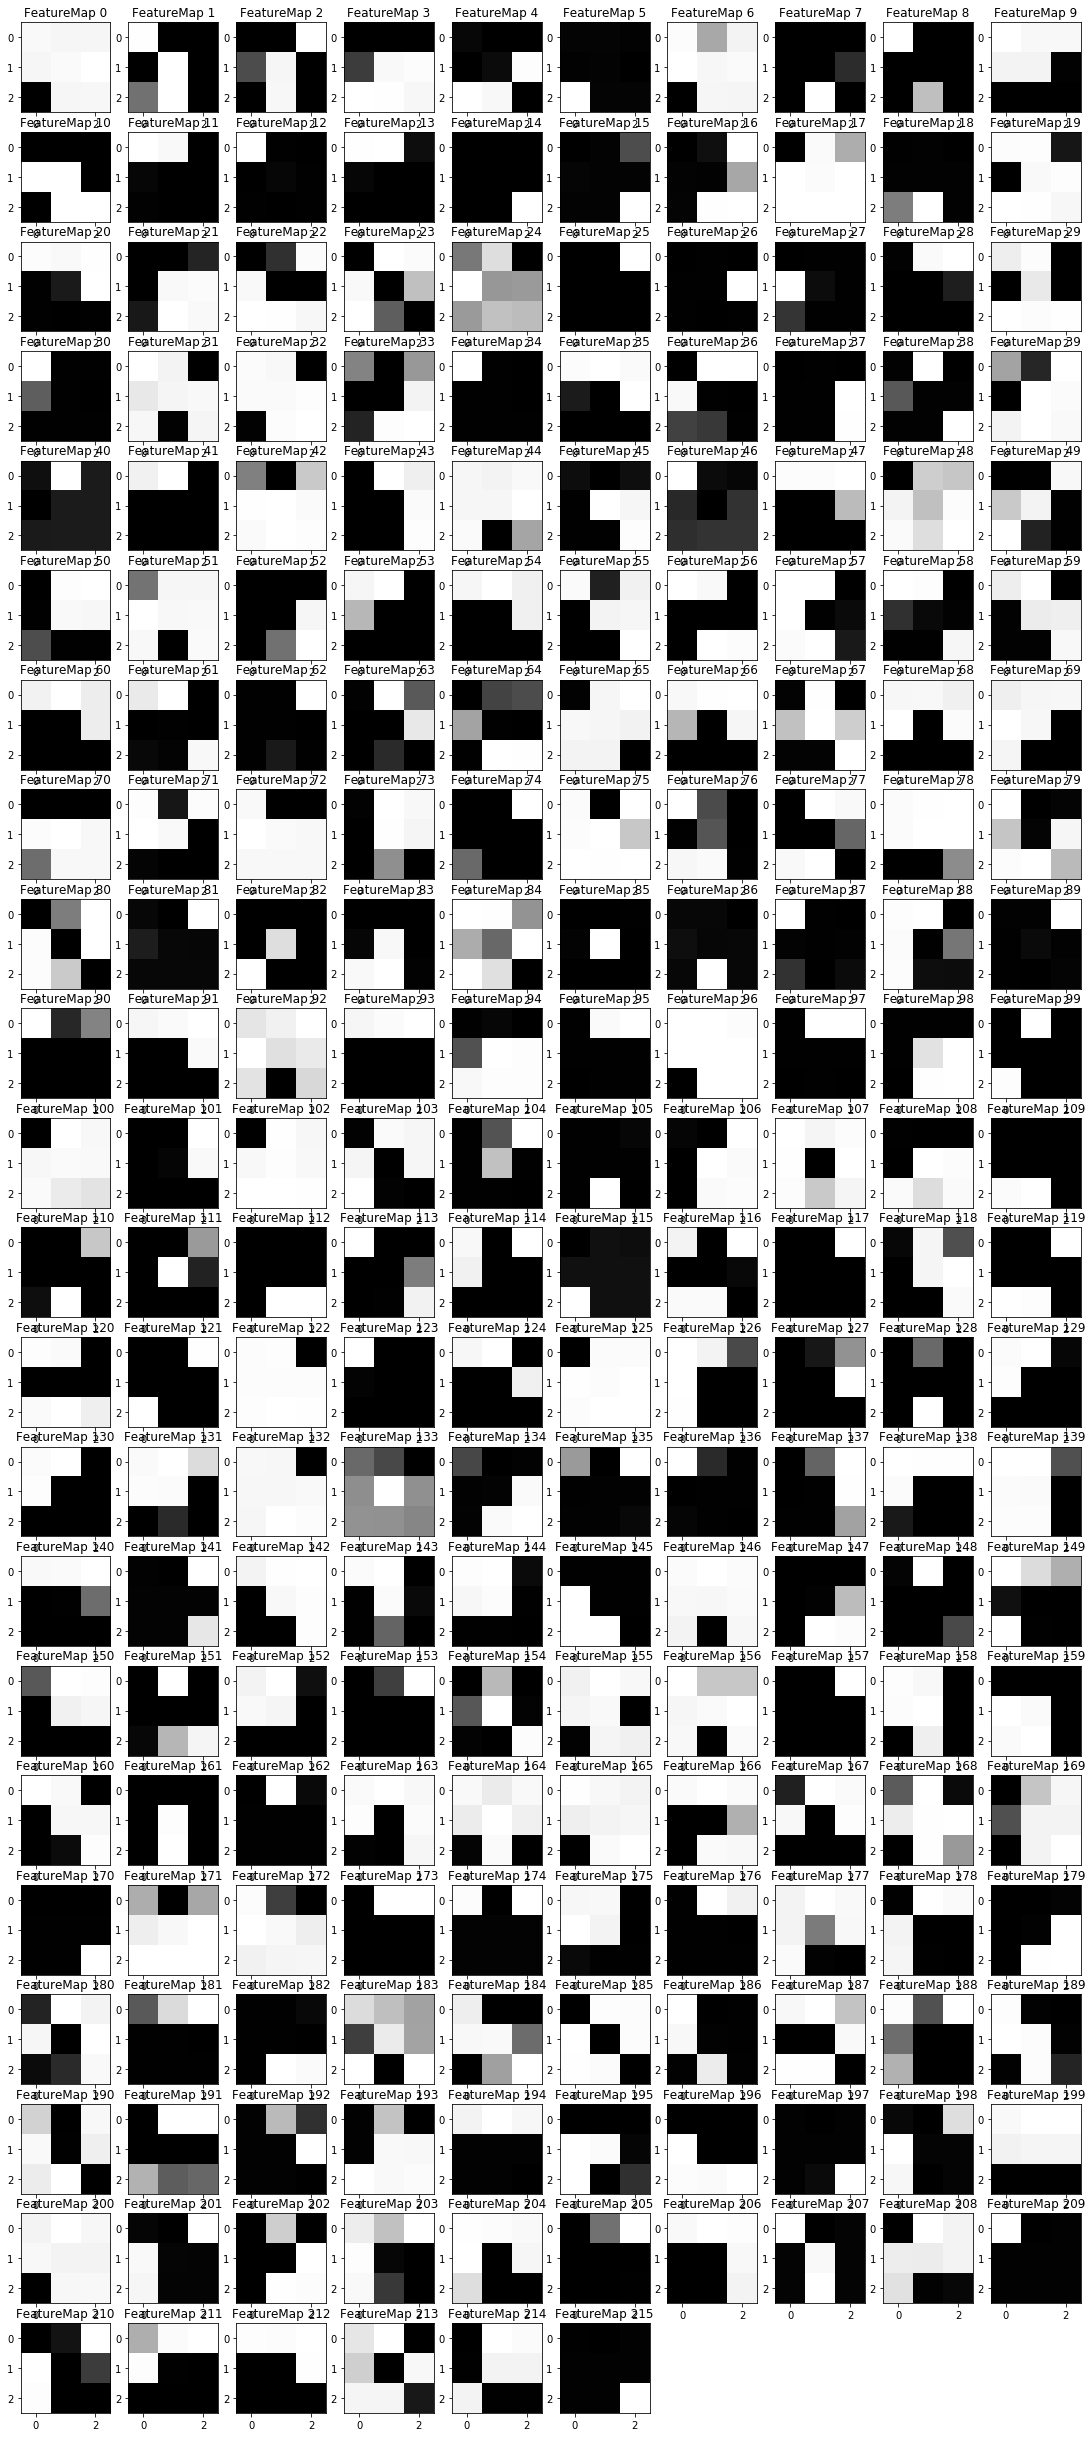

In [21]:
images = {'LED sign': imgs[6][2],
          'Normal sign': imgs[4][2]}

with tf.Session() as sess:
    saver.restore(sess, file_name)
    for title, img in images.items():
        dsp.display(dsp.Markdown(f'#### Data for {title}'))
        plt.figure(figsize=(3, 3))
        plt.imshow(img,)
        plt.title('Original image')
        plt.show()
        outputFeatureMap(img[None, ...], grayscale_standardization, title='Grayscale standardization')
        outputFeatureMap(img[None, ...], rgb_standardization, title='Color standardization')

        dsp.display(dsp.Markdown(f'##### First layer for {title}'))
        outputFeatureMap(img[None, ...], first_convolutional)

        dsp.display(dsp.Markdown(f'##### Second layer {title}'))
        outputFeatureMap(img[None, ...], second_convolutional)

        dsp.display(dsp.Markdown(f'##### Third layer {title}'))
        outputFeatureMap(img[None, ...], third_convolutional)
    
    